In [1]:
# install tensorflow_examples.model.pix2pix
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ah4xezqf
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ah4xezqf


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from scipy import io
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#1. Data loading
#1.1 Prepare alist for image and mask

images=[]
masks=[]
file_directory = '/content/drive/MyDrive/carvana-masking-challenge/train'

In [5]:
#1.2 Load the images
image_dir = os.path.join(file_directory,'inputs')
image_list = os.listdir(image_dir)

def sortchars(x):
    return(x[:15]) 

for image_file in sorted(image_list, key = sortchars):   
  print(image_file)
  img = cv2.imread(os.path.join(image_dir,image_file), cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img,(128,128))
  images.append(img)

00087a6bd4dc_01.jpg
00087a6bd4dc_02.jpg
00087a6bd4dc_03.jpg
00087a6bd4dc_04.jpg
00087a6bd4dc_05.jpg
00087a6bd4dc_06.jpg
00087a6bd4dc_07.jpg
00087a6bd4dc_08.jpg
00087a6bd4dc_09.jpg
00087a6bd4dc_10.jpg
00087a6bd4dc_11.jpg
00087a6bd4dc_12.jpg
00087a6bd4dc_13.jpg
00087a6bd4dc_14.jpg
00087a6bd4dc_15.jpg
00087a6bd4dc_16.jpg
03a857ce842d_01.jpg
03a857ce842d_02.jpg
03a857ce842d_03.jpg
03a857ce842d_04.jpg
03a857ce842d_05.jpg
03a857ce842d_06.jpg
03a857ce842d_07.jpg
03a857ce842d_08.jpg
03a857ce842d_09.jpg
03a857ce842d_10.jpg
03a857ce842d_11.jpg
03a857ce842d_12.jpg
03a857ce842d_13.jpg
03a857ce842d_14.jpg
03a857ce842d_15.jpg
03a857ce842d_16.jpg
0495dcf27283_01.jpg
0495dcf27283_02.jpg
0495dcf27283_03.jpg
0495dcf27283_04.jpg
0495dcf27283_05.jpg
0495dcf27283_06.jpg
0495dcf27283_07.jpg
0495dcf27283_08.jpg
0495dcf27283_09.jpg
0495dcf27283_10.jpg
0495dcf27283_11.jpg
0495dcf27283_12.jpg
0495dcf27283_13.jpg
0495dcf27283_14.jpg
0495dcf27283_15.jpg
0495dcf27283_16.jpg
04bd942b463b_01.jpg
04bd942b463b_02.jpg


In [6]:
#1.3 Load the mask
mask_dir = mask_dir = os.path.join(file_directory,'masks_png')
mask_list = os.listdir(mask_dir)

def sortchars(x):
    return(x[:15]) 

for mask_file in sorted(mask_list, key = sortchars):   
  mask = cv2.imread(os.path.join(mask_dir,mask_file), cv2.IMREAD_GRAYSCALE)
  mask= cv2.resize(mask,(128,128))
  masks.append(mask)

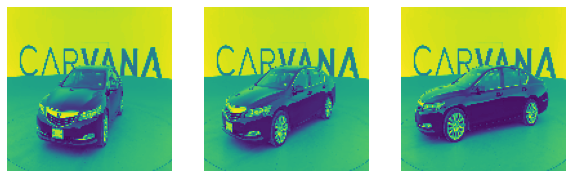

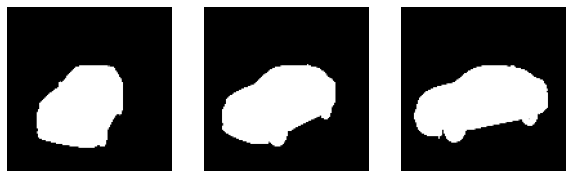

In [7]:
#1.5 Check some examples
plt.figure(figsize=(10,4))
for i in range(1,4):
  plt.subplot(1,3,i)
  img_plot = images[i]
  plt.imshow(img_plot)
  plt.axis('off')
  
plt.show()

plt.figure(figsize=(10,4))
for i in range(1,4):
  plt.subplot(1,3,i)
  mask_plot = masks[i]
  plt.imshow(mask_plot, cmap='gray')
  plt.axis('off')

plt.show()

In [8]:
#1.4 Convert images and masks into numpy array
images = np.expand_dims(images,axis=-1)
images_np = np.array(images)
masks_np = np.array(masks)

In [9]:
#2. Data Preprocessing
#2.1 Expand the mask dimension
masks_np_exp = np.expand_dims(masks_np,axis=-1)
# Check the mask output
print(masks[0].min(),masks[0].max())


0 255


In [10]:
#2.2 Change the mask value (1. normalize the value, 2. encode the numerical encoding)
converted_masks = np.round(masks_np_exp/225)
converted_masks = 1 - converted_masks

In [11]:
#2.3 Normalize the images
converted_images = images_np/225.0

In [12]:
#2.4 Do train-test split
from sklearn.model_selection import train_test_split

SEED = 12345
x_train, x_test,y_train,y_test = train_test_split(converted_images,converted_masks,test_size=0.2,random_state=SEED)


In [13]:
#2.5 Convert the numpy array data into tensor slices
train_x = tf.data.Dataset.from_tensor_slices(x_train)
test_x = tf.data.Dataset.from_tensor_slices(x_test)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
test_y = tf.data.Dataset.from_tensor_slices(y_test)


In [14]:
#2.6 Zip tensor slice into dataset
train = tf.data.Dataset.zip((train_x,train_y))
test = tf.data.Dataset.zip((test_x,test_y))

In [15]:
#2.7 Convert into prefetch dataset
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 800//BATCH_SIZE
VALIDATION_STEP = 200//BATCH_SIZE

train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train = train.prefetch(buffer_size=AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [24]:
#3. Prepare model
#create a modified version of U-Net
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

#
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

#function tocreate the entire model
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

#Define the model
OUTPUT_CLASSES = 2
model = unet_model(output_channels=OUTPUT_CLASSES)

In [27]:
# Compile the model and display the model structure
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           [(None, 64, 64, 96)  1841984     ['input_4[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

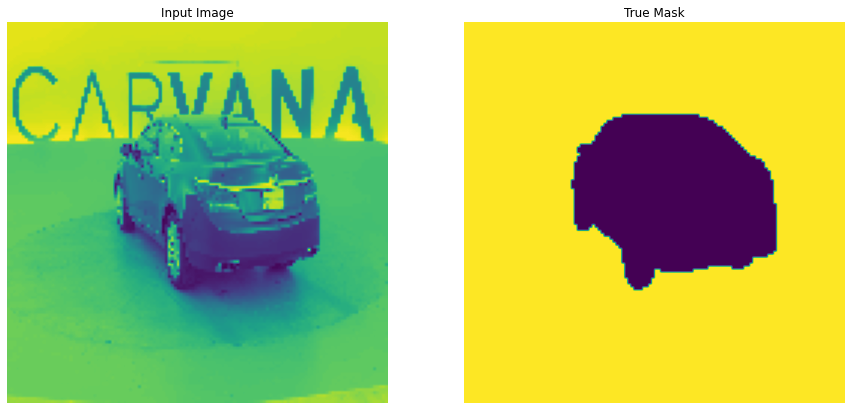

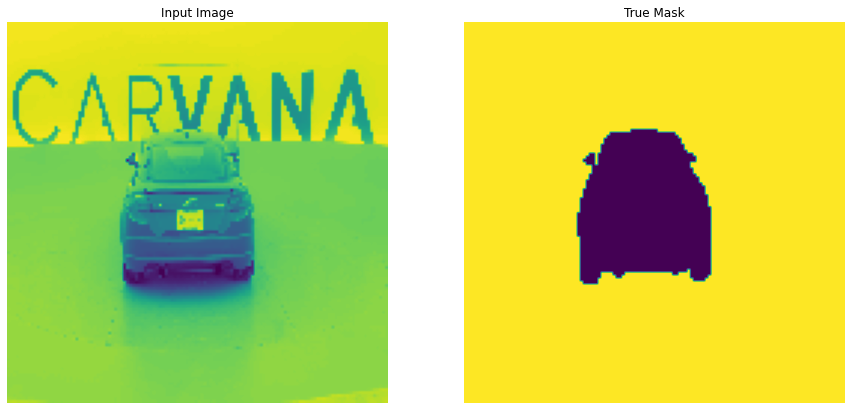

In [18]:
#CReate a function to display some examples
def display(display_list):
  plt.figure(figsize=(15,15))
  title = ['Input Image','True Mask','Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  
  plt.show()

for images, masks in train.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image,sample_mask])


In [28]:
#Create a function to process predicted mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask,axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

#Create a function to display prediction
def show_prediction(dataset=None,num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0],create_mask(pred_mask)[0]])

    else:
      display([sample_image,sample_mask,create_mask(model.predict(sample_image, [tf.newaxis,...]))[0]])

#Custom callback to display result during training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_prediction()
    print('\n Sample prediction after epoch {}\n'. format(epoch+1))

#Tensorflow callback
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%y%m%d-%H%M%S")
#tb_callback = tf.keras.callbacks.Tensorboard(log_dir, histogram_freq=1,profile_batch=0)
tb_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,profile_batch=0)


#Start to do the training
EPOCH = 20

history = model.fit(train, epochs = EPOCH, steps_per_epoch=STEPS_PER_EPOCH,
                      validation_steps=VALIDATION_STEP,
                      validation_data=test,
                      callbacks=[DisplayCallback(),tb_callback])
  

Epoch 1/20


ValueError: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
#Deploy model by using the show_prediction functions created before
show_prediction(test, 3)